# Weed & Rose Detection with Ultralytics YOLOv8s
This notebook trains a YOLOv8s model to detect weeds and roses from an annotated dataset of bounding boxes. It defines environment settings, configuration parameters, and the training process — with options for augmentation, reproducibility, and automatic folder management.

# 1. Environment & Versions


In [1]:
# Make sure the notebook kernel is the conda env: Python (yolo)
import sys, platform, torch, os
import albumentations as A
print("Python:", sys.version)
print("OS:", platform.platform())
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Albumentations version:", A.__version__)

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
CUDA available: True
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Albumentations version: 2.0.8


# 2. Paths & Config


In [2]:
from pathlib import Path
import yaml

PROJECT_ROOT = Path(r"D:/Ai Systems Group")
DATA_YAML    = PROJECT_ROOT / "data/weeds_yolo/data.yaml"
OUT_DIR      = PROJECT_ROOT / "work_dirs"

CFG = {
    "data": str(DATA_YAML),
    "model": "yolov8s.pt",
    "epochs": 120,
    "batch": 6,
    "imgsz": 1280,
    "workers": 5,
    "device": 0,
    "project": str(OUT_DIR),
    "name": "yolov8s-weeds",
    "exist_ok": False,
    "plots": True,
    "patience": 25,
    "seed": 42,
    # "close_mosaic": 10,
    # "cache": "ram",
}
print(DATA_YAML) # Sanity check to see which yaml file is used for training

D:\Ai Systems Group\data\weeds_yolo\data.yaml


# 3. Inspect dataset YAML

In [3]:
with open(DATA_YAML, "r", encoding="utf-8") as f:
    ds = yaml.safe_load(f)
print(ds)


{'path': 'D:/Ai Systems Group/data/weeds_yolo', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'Rose', 1: 'Weed'}}


# 4. Albumentations Augmentation Pipeline


In [4]:
import albumentations as A
import math

albu_train = A.Compose([
    A.MotionBlur(p=0.02, blur_limit=5),
    A.MedianBlur(p=0.02, blur_limit=5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.CLAHE(clip_limit=(1.0, 3.0), tile_grid_size=(8, 8), p=0.3),
    A.ToGray(p=0.05),
    A.ImageCompression(quality_range=(70, 100), p=0.2),

    A.GaussNoise(
        std_range=(math.sqrt(10.0) / 255.0, math.sqrt(40.0) / 255.0),
        mean_range=(0, 0),
        p=0.15
    ),
    # A.RandomCrop(p=1, )
])

# 5. Model Training

In [5]:
from ultralytics import YOLO

model = YOLO(CFG["model"])
results = model.train(
    data=CFG["data"],
    epochs=CFG["epochs"],
    imgsz=CFG["imgsz"],
    batch=CFG["batch"],
    workers=CFG["workers"],
    device=CFG["device"],
    project=CFG["project"],
    name=CFG["name"],
    exist_ok=CFG["exist_ok"],
    patience=CFG["patience"],
    seed=CFG["seed"],
    plots=True,

    cls=1.0,
    weight_decay = 0.001,
    lrf = 0.0005,

    # --Augmentations--
    hsv_h=0.015, hsv_s=0.50, hsv_v=0.35,
    degrees=15.0, translate=0.06, scale=0.20, shear=5.0,
    perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=0.5,
    mixup=0.1,
    close_mosaic=10,
    augmentations=albu_train,
)
results


Ultralytics 8.3.227  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, augmentations=Compose([
  MotionBlur(p=0.02, allow_shifted=True, angle_range=(0.0, 360.0), blur_limit=(3, 5), direction_range=(-1.0, 1.0)),
  MedianBlur(p=0.02, blur_limit=(3, 5)),
  RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.15, 0.15), contrast_limit=(-0.15, 0.15), ensure_safe_range=False),
  CLAHE(p=0.3, clip_limit=(1.0, 3.0), tile_grid_size=(8, 8)),
  ToGray(p=0.05, method='weighted_average', num_output_channels=3),
  ImageCompression(p=0.2, compression_type='jpeg', quality_range=(70, 100)),
  GaussNoise(p=0.15, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.01240108886340541, 0.02480217772681082)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True), auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache

D:\Anaconda\envs\yolo\lib\site-packages\albumentations\core\composition.py:465: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  super().__init__(


val: Fast image access  (ping: 0.50.6 ms, read: 688.3143.1 MB/s, size: 9031.6 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo\labels\val.cache... 26 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 26/26 6.9Kit/s 0.0s
Plotting labels to D:\Ai Systems Group\work_dirs\yolov8n-weeds3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00103125), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 5 dataloader workers
Logging results to D:\Ai Systems Group\work_dirs\yolov8n-weeds3
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/120      5.29G      2.513      6.657      2.233        107       1280: 100% ━━━━━━━━━━━━ 30/30 1.7it/s 17.6s0.4s
                 Class     Images  Instances     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020A1CE05480>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

# View training curves

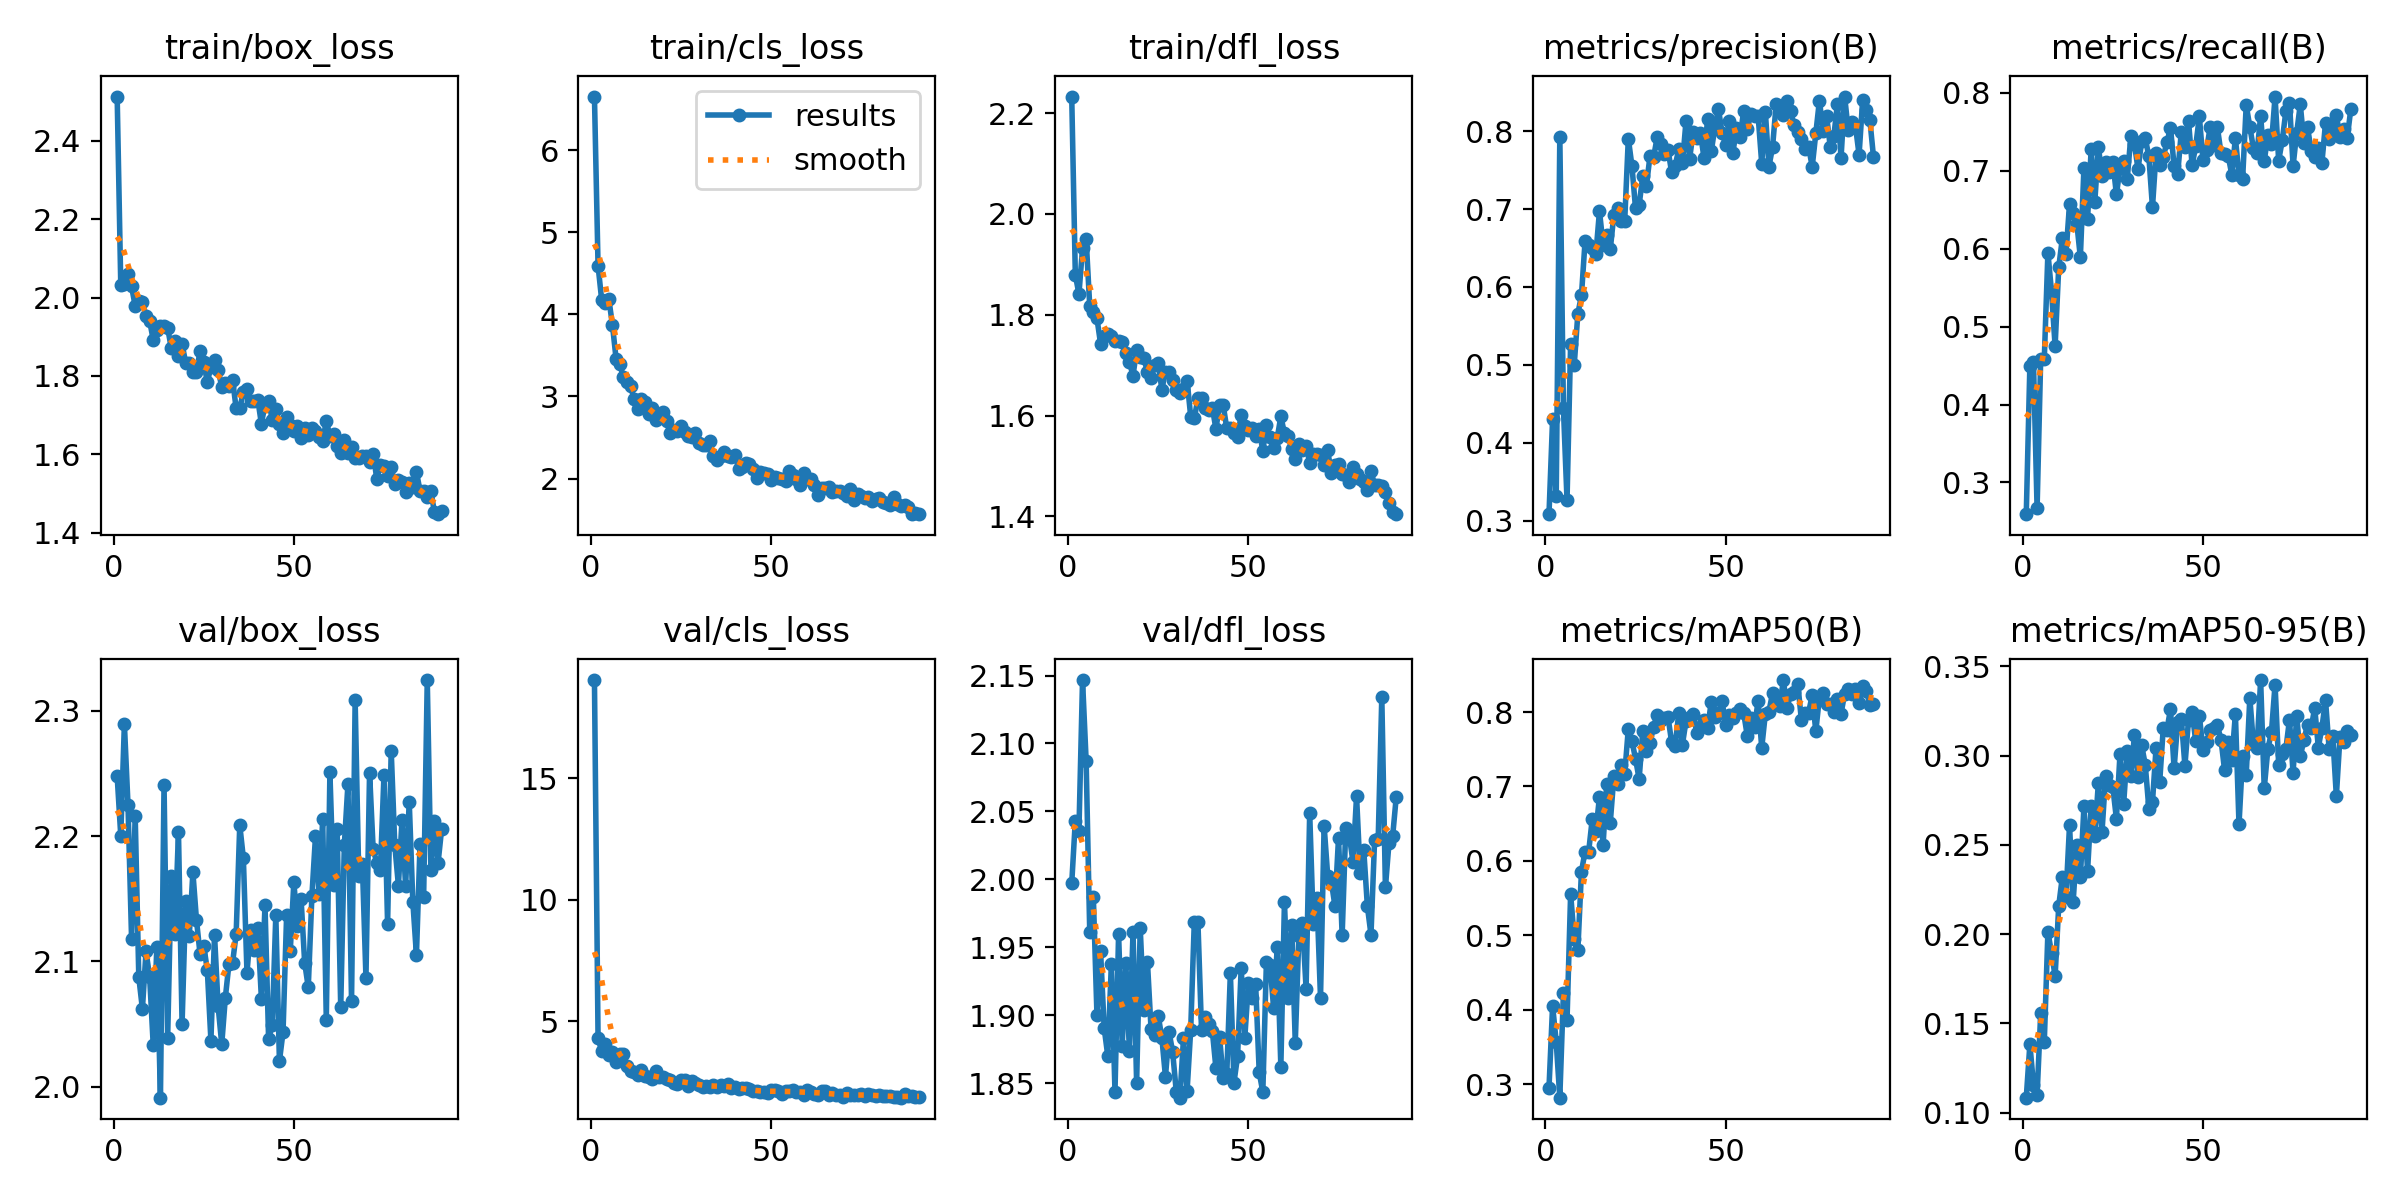

In [9]:
from IPython.display import display
from PIL import Image

run_dir = OUT_DIR / "yolov8s-weeds"
img = run_dir / "results.png"
if img.exists():
    display(Image.open(img))
else:
    print("results.png not found yet:", img)


# Validate on val set (metrics + plots)

In [7]:
metrics = model.val(
    data=CFG["data"],
    project=str(OUT_DIR),
    name=f"{CFG['name']}-val",
    plots=True
)
metrics


Ultralytics 8.3.227  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2309.1367.1 MB/s, size: 8831.8 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo\labels\val.cache... 26 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 26/26  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.2it/s 9.1s26.6s
                   all         26        402      0.819      0.776      0.845      0.344
                  Rose         26        130      0.869      0.813      0.876      0.336
                  Weed         26        272      0.769      0.739      0.815      0.351
Speed: 20.7ms preprocess, 28.3ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to D:\Ai Systems Group\work_dirs\yolov8n-weeds-val3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020A3DA4F580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.048

# Predict on some images

In [8]:
VAL_IMAGES = Path(ds["path"]) / ds["val"]  # images/val folder
pred = model.predict(
    source=str(VAL_IMAGES),
    project=str(OUT_DIR),
    name=f"{CFG['name']}-pred",
    save=True,      # save images with drawn boxes
    save_txt=True,  # save YOLO txt predictions
    conf=0.25       # tweak for precision/recall trade-off
)
pred[:2]



image 1/26 D:\Ai Systems Group\data\weeds_yolo\images\val\073a3524-IMG_3359.JPG: 960x1280 8 Roses, 19 Weeds, 70.4ms
image 2/26 D:\Ai Systems Group\data\weeds_yolo\images\val\078e9af6-IMG_3424.JPG: 960x1280 6 Roses, 14 Weeds, 27.2ms
image 3/26 D:\Ai Systems Group\data\weeds_yolo\images\val\149e798d-IMG_3340.JPG: 960x1280 7 Roses, 5 Weeds, 24.3ms
image 4/26 D:\Ai Systems Group\data\weeds_yolo\images\val\2ab9900c-IMG_3303.JPG: 960x1280 5 Roses, 5 Weeds, 26.1ms
image 5/26 D:\Ai Systems Group\data\weeds_yolo\images\val\308c1605-IMG_3364.JPG: 960x1280 7 Roses, 17 Weeds, 26.8ms
image 6/26 D:\Ai Systems Group\data\weeds_yolo\images\val\30b69407-IMG_3305.JPG: 960x1280 5 Roses, 5 Weeds, 26.5ms
image 7/26 D:\Ai Systems Group\data\weeds_yolo\images\val\4c81fabd-IMG_3381.JPG: 960x1280 4 Roses, 7 Weeds, 24.2ms
image 8/26 D:\Ai Systems Group\data\weeds_yolo\images\val\4e57b6b0-DJI_0206.JPG: 736x1280 6 Roses, 16 Weeds, 71.1ms
image 9/26 D:\Ai Systems Group\data\weeds_yolo\images\val\4f1ba166-IMG_3377

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Rose', 1: 'Weed'}
 obb: None
 orig_img: array([[[195, 197, 205],
         [197, 199, 207],
         [183, 186, 194],
         ...,
         [221, 233, 239],
         [207, 219, 225],
         [194, 206, 212]],
 
        [[202, 204, 212],
         [192, 194, 202],
         [176, 179, 187],
         ...,
         [220, 232, 238],
         [209, 221, 227],
         [203, 215, 221]],
 
        [[182, 185, 193],
         [165, 168, 176],
         [156, 159, 167],
         ...,
         [213, 226, 234],
         [206, 217, 225],
         [206, 217, 225]],
 
        ...,
 
        [[104,  78,  62],
         [103,  77,  61],
         [105,  76,  61],
         ...,
         [114, 122, 129],
         [115, 123, 130],
         [117, 125, 132]],
 
        [[104,  78,  62],
         [104,  78,  62],
         [105,  76,  61],
         ...,
         